### COVID Global Forecast:
In the context of the global COVID-19 pandemic, Kaggle has launched several challenges in order to provide useful insights that may answer some of the open scientific questions about the virus. This is the case of the COVID19 Global Forecasting, in which participants are encouraged to fit worldwide data in order to predict the pandemic evolution, hopefully helping to determine which factors impact the transmission behavior of COVID-19. We will be looking at only India's data and try to predict the future trends of this disease in India using Linear regression.

TABLE OF CONTENTS

Exploratory data analysis (EDA)

1.1. COVID-19 global tendency

1.2. COVID-19 tendency in India


Data enrichment

2. Join data, filter dates and clean missings

Predictions for the early stages of the transmission

3 Linear Regression for one country - India



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
submission_example = pd.read_csv("../input/covid19-global-forecasting-week-4/submission.csv")
test = pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")
train = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")
train.Province_State.fillna("None", inplace=True)
display(train.head(5))
display(train.describe())
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print('Number of days data recorded for India are:',len(train.loc[train['Country_Region']=='India',:]))

### 1. Exploratory data analysis (EDA) 
#### 1.1. COVID-19 global tendency
Let's see a few plots of the worldwide tendency to see if we can extract some insights:

In [ ]:
#confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Observations: The curve resembles a typical epidemiology model like SIR. SIR models present a large increasing in the number of infections that, once it reaches the maximum of the contagion, decreases with a lower slope. 
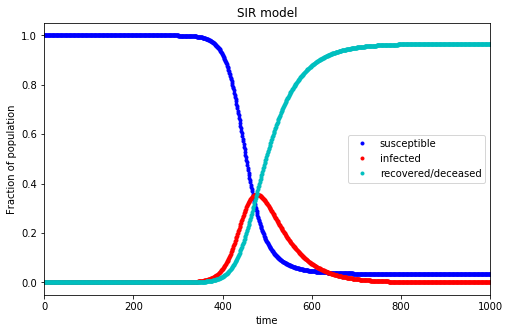

#### 1.2. COVID-19 tendency in India

In [ ]:
confirmed_total_date_India = train[train['Country_Region']=='India'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_India = train[train['Country_Region']=='India'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_India = confirmed_total_date_India.join(fatalities_total_date_India)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date_India.plot(ax=ax1)
ax1.set_title("India confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_India.plot(ax=ax2, color='orange')
ax2.set_title("India deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)


With almost 10.000 confirmed cases, India shows an alarming scenario of COVID-19. The infections curve is very steep. India hopes that the lockdown will have effect and the peak will soon be achieved after which the cases must stop increasing exponentially.

### 2.Join data, filter dates and clean missings 
First of all, we perform some pre-processing prepare the dataset, consisting on:

Join data. Join train/test to facilitate data transformations
Filter dates. According to the challenge conditions, remove ConfirmedCases and Fatalities post 2020-03-12. Create additional date columns
Missings. Analyze and fix missing values

In [ ]:
all_data = train.copy()
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
# all_data['ForecastId'].fillna(-1, inplace=True)

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-04-01'])

Missing values for "ConfirmedCases" and "Fatalities" have been replaced by 0, which may be dangerous if we do not remember it at the end of the process. 
A new column "Day" has been created, as a day counter starting from the first date

### 3. Linear Regression for one country : India
Since we are interested into predicting the future time evolution of the pandemic, our first approach consists on a simple Linear Regression. However, remind that the evolution is not linear but exponential (only in the beginning of the infection), so that a preliminar log transformation is needed.

Visual comparison of both cases for India:
(we will use data for 40 days betwwn day 41 and 80 ie 3rd March to 11th April)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))


y1 = all_data[(all_data['Country_Region']=='India') & (all_data['Day_num']>41) & (all_data['Day_num']<=80)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("India ConfirmedCases between days 41 and 80")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Country_Region']=='India') & (all_data['Day_num']>41) & (all_data['Day_num']<=80)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("India Log ConfirmedCases between days 41 and 80")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

As you see, the log transformation results in a fancy straight-like line, which is awesome for Linear Regression.
Let's build a linear regression model, with only one feature i.e. day number.

In [ ]:
data = all_data[(all_data['Country_Region']=='India') & (all_data['Day_num']>41)]
features = ['ConfirmedCases','Fatalities','Day_num']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred



In [ ]:
X_train= np.array(list(data.loc[(data['Day_num']>41) & (data['Day_num']<=80), 'Day_num'])).reshape(-1,1)
y_train= list(data.loc[(data['Day_num']>41) & (data['Day_num']<=80), 'ConfirmedCases']) 
X_test= np.array(list(data.loc[(data['Day_num']>80), 'Day_num'])).reshape(-1,1)
print('Predicted cases on the 81st day i.e 12th April: ',np.expm1(list(lin_reg(X_train, y_train, X_test)[1]))[0])
print('Actual cases on the 81st day i.e 12th April: ',list(np.expm1(data.loc[(data['Day_num']==81), 'ConfirmedCases']))[0])

Okay, so we successfully built a lin reg model and we were able to predict the number of cases on the next day. This model will hold true only for the initial phases of the spread when cases are incresing exponentially. Once the plateau or peak is reached, this model will fail. 
## Here's hoping the model fails ASAP.